# Tutorial 1: Working with OpenStreetMap

Within this tutorial, we will explore the power of OpenStreetMap. We will learn how to extract information from OpenStreetMap, how you can explore and visualize this, and how to use it for some basic analysis.

<h2>Tutorial Outline<span class="tocSkip"></span></h2>
<hr>
<div class="toc"><ul class="toc-item">
<li><span><a href="#1.-Introducing the packages" data-toc-modified-id="1.-Introducing-the-packages-2">1. Introducing the packages</a></span></li>
<li><span><a href="#2.-Extracting land-use information from OpenStreetMap" data-toc-modified-id="2.-Extracting-landuse-information-3">2. Extract and visualize land-use information from OpenStreetMap</a></span></li>
<li><span><a href="#3.-Visualize and rasterize land-use information" data-toc-modified-id="3.-Visualize-Rasterize-4">3. Rasterize land-use information</a></span></li>
<li><span><a href="#4.-Extracting buildings from OpenStreetMap" data-toc-modified-id="4.-Extracting-buildings-5">4. Extracting buildings from OpenStreetMap</a></span></li>
<li><span><a href="#5.-Analyze and visualize building stock" data-toc-modified-id="5.-Analyze-buildings-6">5. Analyze and visualize building stock</a></span></li>
<li><span><a href="#6.-Extracting roads from OpenStreetMap" data-toc-modified-id="4.-Extracting-roads-5">6. Extracting roads from OpenStreetMap</a></span></li>
<li><span><a href="#7.-Plot Routes Using OpenStreetMap and Folium" data-toc-modified-id="5.-Plot-routes-6">7. Plot Routes Using OpenStreetMap and Folium</a></span></li></ul></div>

## Learning Objectives
<hr>

- .
- .
- .
- .
- .
- .

## 1.Introducing the packages
<hr>

Within this tutorial, we are going to make use of the following packages: 

[**GeoPandas**](https://geopandas.org/) is a Python packagee that extends the datatypes used by pandas to allow spatial operations on geometric types.

[**OSMnx**](https://osmnx.readthedocs.io/) is a Python package that lets you download geospatial data from OpenStreetMap and model, project, visualize, and analyze real-world street networks and any other geospatial geometries. You can download and model walkable, drivable, or bikeable urban networks with a single line of Python code then easily analyze and visualize them. You can just as easily download and work with other infrastructure types, amenities/points of interest, building footprints, elevation data, street bearings/orientations, and speed/travel time.

[**NetworkX**](https://networkx.org/) is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.

[**Matplotlib**](https://matplotlib.org/) is a comprehensive Python package for creating static, animated, and interactive visualizations in Python. Matplotlib makes easy things easy and hard things possible.

[**Geocube**](https://corteva.github.io/geocube) is a Python package to convert geopandas vector data into rasterized data.

[**xarray**](https://docs.xarray.dev/) is a Python package that allows for easy and efficient use of multi-dimensional arrays.

[**Rasterio**](https://rasterio.readthedocs.io/) is a Python package to organize and store gridded raster datasets such as satellite imagery and terrain models. Rasterio reads and writes these formats and provides a Python API based on Numpy N-dimensional arrays and GeoJSON.

*We will first need to install these packages in the cell below. Uncomment them to make sure we can pip install them*

In [1]:
#!pip install osmnx
#!pip install geopandas
#!pip install geocube
#!pip install contextily

And we will import these packages in the cell below:

In [78]:
import osmnx as ox
import numpy as np
import networkx as nx
import contextily as cx
import matplotlib

from matplotlib.colors import LinearSegmentedColormap,ListedColormap
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from IPython.display import IFrame
from geocube.api.core import make_geocube

%matplotlib inline

## 2. Extract and visualize land-use information from OpenStreetMap
<hr>

The first step is to define which area you want to focus on. In the cell below, you will now read "Steenwijk, The Netherlands". Change this to any random or municipality in the Netherlands that (1) you can think of and (2) will work. 

In some cases, the function does not recognize the location. You could either try a different phrasing or try a different location. Many parts of the Netherlands should work.

In [3]:
place_name = "Steenwijk, The Netherlands"
area = ox.geocode_to_gdf(place_name)

Now let us visualize the bounding box of the area. As you will notice, we also estimate the size of the area. If the area size is above 50km2, or when you have many elements within your area (for example the amsterdam city centre), extracting the data from OpenStreetMap may take a little while. 

Text(0.5, 1.0, 'Steenwijk, The Netherlands. Total area: 31 km2')

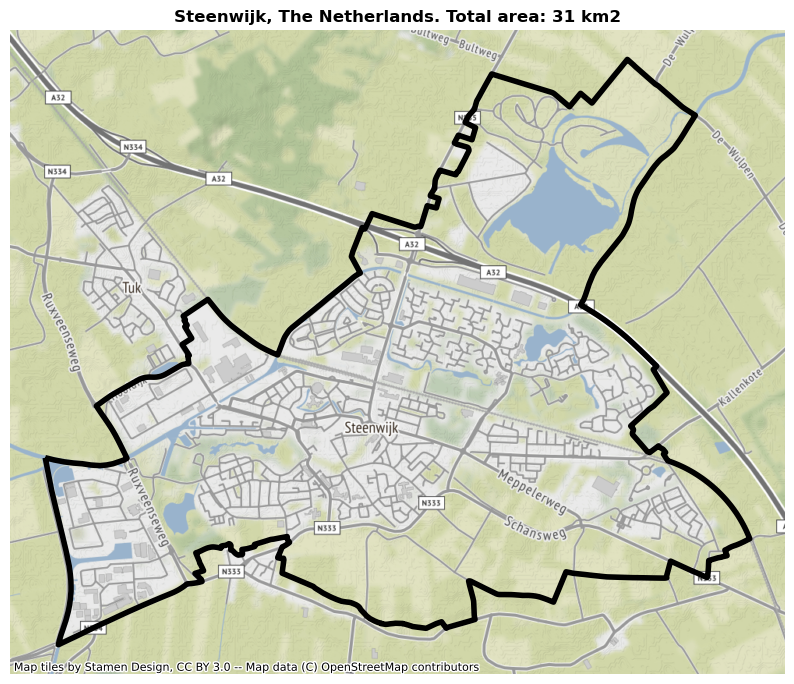

In [4]:
area_to_check = area.to_crs(epsg=3857)
ax = area_to_check.plot(figsize=(10, 10), color="none", edgecolor="k", linewidth=4)
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()
cx.add_basemap(ax, zoom=14)

size = int(area_to_check.area/1e6)

ax.set_title("{}. Total area: {} km2".format(place_name,size),fontweight='bold')

Now we are satisfied with the selected area, we are going to extract the land-use information from OpenStreetMap. To find the right information from OpenStreetMap, we use **tags**.

As you will see in the cell below, we use the tags *"landuse"* and *"natural"*. We need to use the *"natural"* tag to ensure we also obtain water bodies and other natural elements. 

In [5]:
tags = {'landuse': True, 'natural': True}   
landuse = ox.geometries_from_place(place_name, tags)

To ensure we really only get the area that we want, we use geopandas's `clip` function to only keep the area we want. This function does exactly the same as the `clip` function in QGIS.

In [6]:
landuse = landuse.clip(area)

When we want to visualize or analyse the data, we want all information in a single column. However, at the moment, all information that was tagged as *"natural"*, has no information stored in the *"landuse"* tags. It is, however, very convenient if we can just use a single column for further exploration of the data. 

To overcome this issue, we need to add the missing information to the landuse column, as done below.

In [7]:
landuse.loc[landuse.natural=='water','landuse'] = 'water'
landuse.loc[landuse.natural=='beach','landuse'] = 'beach'
landuse.loc[landuse.natural=='grassland','landuse'] = 'grass'
landuse.loc[landuse.natural=='wetland','landuse'] = 'wetlands'
landuse = landuse.dropna(subset=['landuse'])

Our next step is to prepare the visualisation of a map. What better way to explore land-use information than plotting it on a map? 

As you will see below, we can create a dictionary with color codes that will color each land-use class based on the color code provided in this dictionary.

In [8]:
color_dict = {  "grass":'#c3eead',               "railway": "#000000",
                "forest":'#1c7426',              "orchard":'#fe6729',
                "residential":'#f13013',         "industrial":'#0f045c',
                "retail":'#b71456',              "education":'#d61181',              
                "commercial":'#981cb8',          "farmland":'#fcfcb9',
                "cemetery":'#c39797',            "construction":'#c0c0c0',
                "meadow":'#c3eead',              "farmyard":'#fcfcb9',
                "plant_nursery":'#eaffe2',       "scrub":'#98574d',
                "allotments":'#fbffe2',          "reservoir":'#8af4f2',
                "static_caravan":'#ff3a55',      "wetlands": "#c9f5e5",
                "water": "#c9e5f5",              "beach": "#ffeead",
                "landfill" : "#B08C4D",          "recreation_ground" : "#c3eead",
                "brownfield" : "#B08C4D",        "village_green" : "#f13013" ,
                "military": "#52514E"}

Unfortunately, OpenSteetMap very often contains elements that have a unique tag. As such, it may be the case that some of our land-use categories are not in the dictionary yet. 

Let's first create an overview of the unique land-use categories within our data through using the `.unique()` function within our dataframe:

In [9]:
landuse.landuse.unique()

array(['water', 'forest', 'grass', 'residential', 'farmland',
       'industrial', 'landfill', 'allotments', 'cemetery',
       'village_green', 'meadow', 'recreation_ground', 'railway',
       'brownfield', 'commercial', 'retail', 'wetlands', 'military',
       'beach'], dtype=object)

Ofcourse we can visually compare the array above with our color_dict, but it is much quicker to use `Sets` to check if there is anything missing:

In [10]:
set(landuse.landuse.unique())-set(color_dict)

set()

In case anything is missing, add them to the color_dict dictionairy and re-run that cell. 

```{tip} text
You can find easily find hexcodes online to find the right colour for each land-use category. Just google it!
```


Our next step is to make sure that we can connect our color codes to our dataframe with land-use categories.

In [11]:
color_dict = {key: color_dict[key]
             for key in color_dict if key not in  list(set(color_dict)-set(landuse.landuse.unique()))}

map_dict = dict(zip(color_dict.keys(),[x for x in range(len(color_dict))]))

landuse['col_landuse'] = landuse.landuse.apply(lambda x: color_dict[x])

Now we can plot the figure!

As you will see in the cell below, we first state that we want to create a figure with a specific figure size. You can change the dimensions to your liking.

Text(0.5, 1.0, 'Steenwijk, The Netherlands')

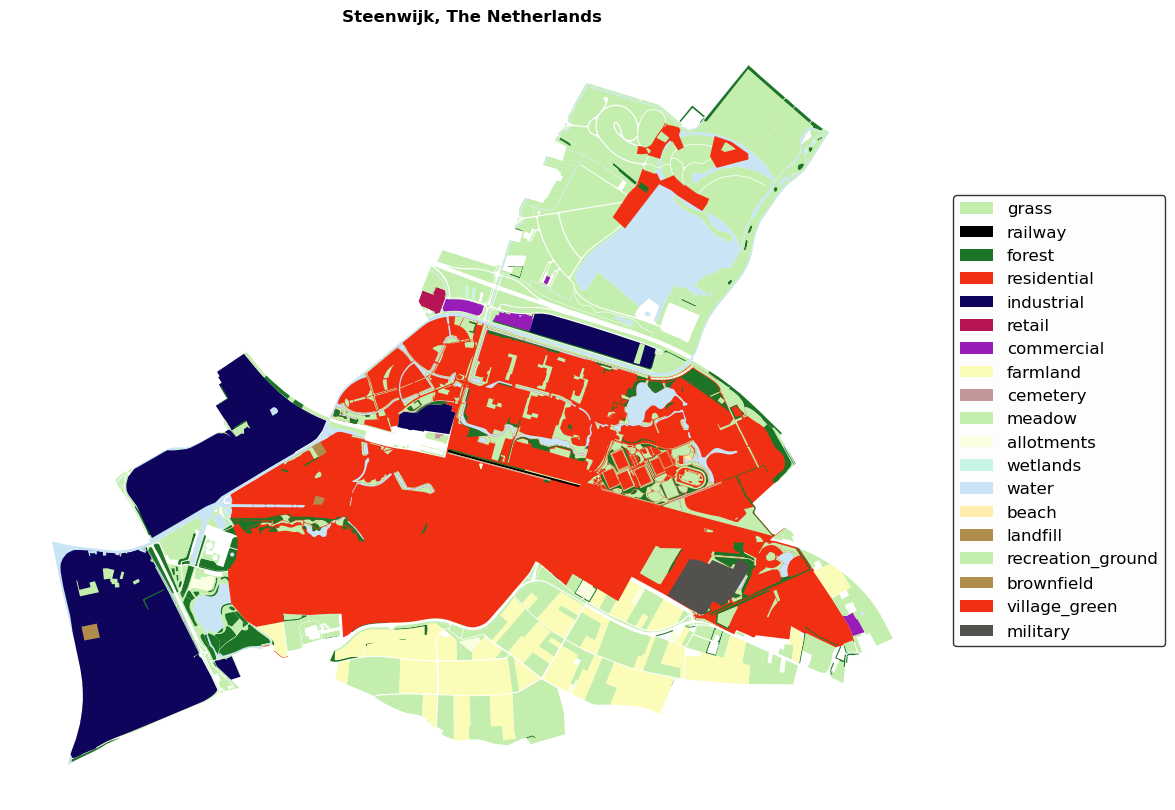

In [12]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))

# add color scheme
color_scheme_map = list(color_dict.values())
cmap = LinearSegmentedColormap.from_list(name='landuse',
                                     colors=color_scheme_map)  

# and plot the land-use map.
landuse.plot(color=landuse['col_landuse'],ax=ax,linewidth=0)

# remove the ax labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()

# add a legend:
legend_elements = []
for iter_,item in enumerate(color_dict):
    legend_elements.append(Patch(facecolor=color_scheme_map[iter_],label=item))        

ax.legend(handles=legend_elements,edgecolor='black',facecolor='#fefdfd',prop={'size':12},loc=(1.02,0.2)) 

# add a title
ax.set_title(place_name,fontweight='bold')

## 3. Rasterize land-use information
<hr>

As you have noticed already during the lecture, and as we will again see next week when using the Google Earth Engine, most land-use data is in raster format. 

In OpenStreetMap everything is stored in vector format. As such, the land-use information we extracted from OpenStreetMap is also in vector format. While it is not always necessary to have this information in raster format, it is useful to know how to convert your data into a raster format.

To do so, we can make use of the **GeoCube** package, which is a newly developed Python package that can very easily convert vector data into a raster format.

The first thing we will need to do is to define all the unique land-use classes and store them in a dictionary:

In [13]:
categorical_enums = {'landuse': landuse.landuse.drop_duplicates().values.tolist()
}

And now we simply use the `make_geocube()` function to convert our vector data into raster data. 

In the `make_geocube()` function, we have to specify several arguments:

- Through the `vector_data` argument we have to state which dataframe we want to rasterize.
- Through the `output_crs` argument we have to state the coordinate reference system (CRS). We use the OpenStreetMap default EPSG:4326.
- Through the `resolution` argument we have to state the resolution. In our case, we will have to set this in degrees. 0.01 degrees is equivalent to roughly 10km around the equator. 
- Through the `categorical_enums` argument we specify the different land-use categories.

Play around with the different resolutions to find the level of detail. The higher the resolution (i.e., the more zeros behind the comma), the longer it will take to rasterize.

In [70]:
landuse_grid = make_geocube(
    vector_data=landuse,
    output_crs="epsg:4326",
    resolution=(-0.0001, 0.0001),
    categorical_enums=categorical_enums
)

Let's explore what this function has given us:

In [71]:
landuse_grid["landuse"]

<xarray.DataArray 'landuse' (y: 391, x: 775)>
array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int16)
Coordinates:
  * y            (y) float64 52.81 52.81 52.81 52.81 ... 52.77 52.77 52.77 52.77
  * x            (x) float64 6.085 6.085 6.085 6.085 ... 6.162 6.162 6.162 6.162
    spatial_ref  int32 0
Attributes:
    name:                 landuse
    long_name:            landuse
    _FillValue:           -1
    categorical_mapping:  landuse_categories

The output above is a typical output of the **xarray** package. 

- The `array` shows the numpy array with the actual values. As you can see, the rasterization process has used the value `-1` for NoData. 
- The `Coordinates` table shows the x (longitude) and y (latitude) coordinates of the array. It has the exact same size as the `array` with land-use values.
- The `Attributes` table specifies the NoData value (the `_FillValue` element, which indeed shows `-1`) and the name of the dataset.

Now let's plot the data to see the result!

Text(0.5, 1.0, 'Rasterized land-use map for Steenwijk, The Netherlands')

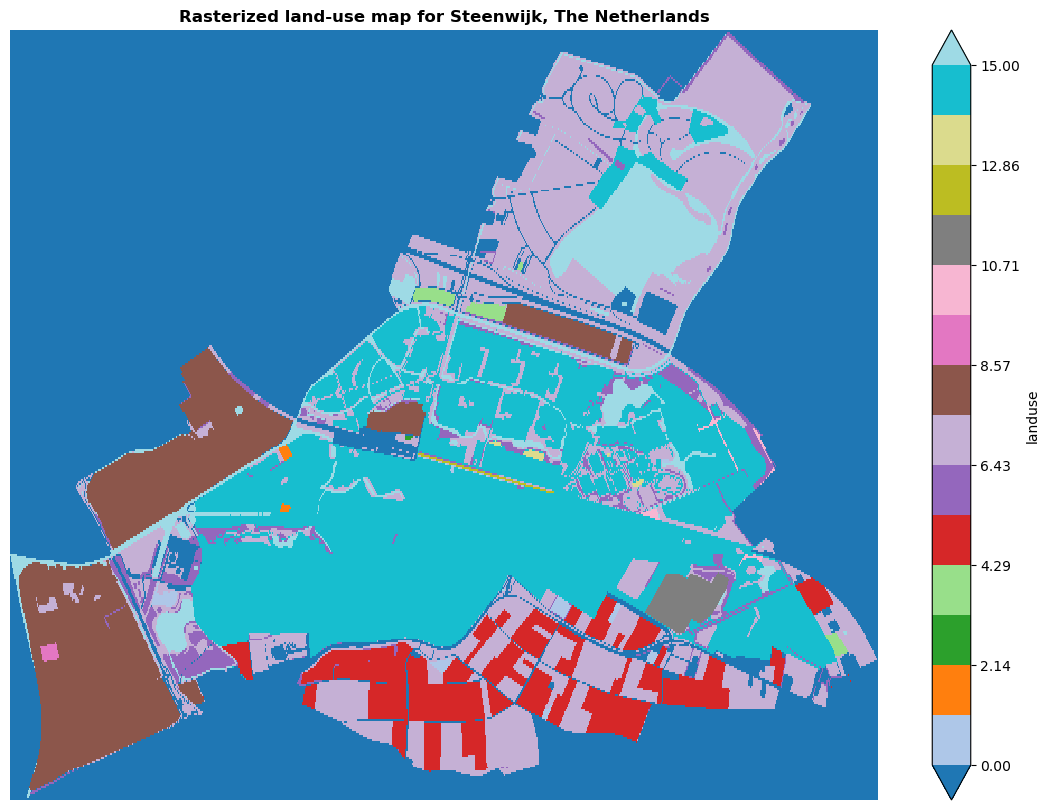

In [189]:
fig, ax = plt.subplots(1, 1,figsize=(14,10))

landuse_grid["landuse"].plot(ax=ax,vmin=0,vmax=15,levels=15,cmap='tab20')

# remove the ax labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()

ax.set_title('Rasterized land-use map for {}'.format(place_name),fontweight='bold')

As we can see in the figure above, the land-use categories have turned into numbers, instead of land-use categories described by a string value. 

This is of course a lot harder to interpret. Let's re-do some parts to make sure we can properly link them back to the original data.

To do so, we will first need to make sure that we know which values (numbers) are connected to each land-use category. Instead of trying to match, let's predefine this ourselves!

We will start with creating a dictionary that allows us to couple a number to each category:

In [73]:
value_dict = dict(zip(landuse.landuse.unique(),np.arange(0,len(landuse.landuse.unique()),1)))

In [142]:
value_dict['nodata'] = -1

And we now use this dictionary to add a new column to the dataframe with the values:

In [143]:
landuse['landuse_value'] = landuse.landuse.apply(lambda x: value_dict[x])

Now let us use the `make_geocube()` function again to rasterize.

In [144]:
landuse_valued = make_geocube(
    vector_data=landuse,
    output_crs="epsg:4326",
    resolution=(-0.0001, 0.0001),
    categorical_enums={'landuse_value': landuse.landuse_value.drop_duplicates().values.tolist()
}
)

And let's use the original `color_dict` dictionary to find the right hex codes for each of the land-use categories

In [146]:
unique_classes = landuse.landuse.drop_duplicates().values.tolist()
colormap_raster = [color_dict[lu_class] for lu_class in unique_classes] 

To plot the new result:

Text(0.5, 1.0, 'Rasterized land-use map for Steenwijk, The Netherlands')

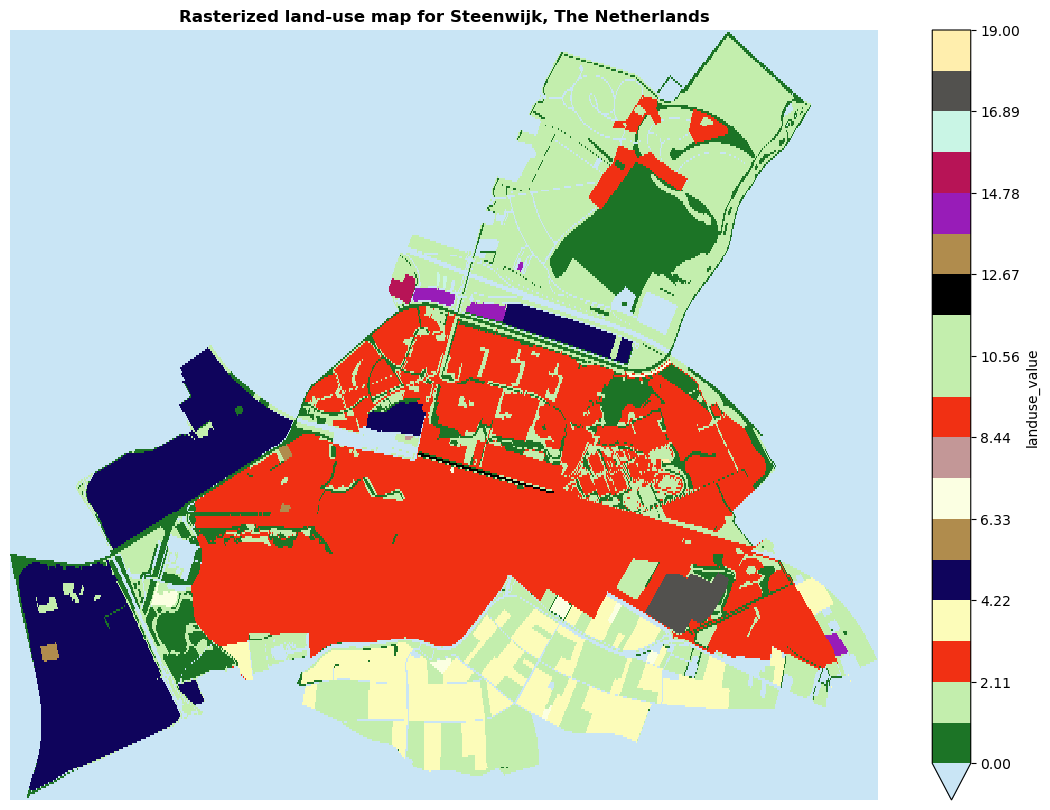

In [188]:
fig, ax = plt.subplots(1, 1,figsize=(14,10))

landuse_valued["landuse_value"].plot(ax=ax,vmin=0,vmax=19,levels=len(unique_classes),colors=colormap_raster)

# remove the ax labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()

ax.set_title('Rasterized land-use map for {}'.format(place_name),fontweight='bold')

But to be honest, this legend is still not entirely what we are looking for. So let's do some Python magic to get a legend like we desire when plotting a land-use map

In [164]:
unique_classes = landuse.landuse.drop_duplicates().values.tolist()
colormap_raster = [color_dict[lu_class] for lu_class in unique_classes] 
color_dict_raster = dict(zip(np.arange(-1,len(landuse.landuse.unique())+1,1),['#ffffff']+colormap_raster))

# We create a colormar from our list of colors
cm = ListedColormap([color_dict_raster[x] for x in color_dict_raster.keys()])

# Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or using another dict maybe could help.
labels = np.array(['nodata'] + unique_classes)
len_lab = len(labels)

# prepare normalizer
## Prepare bins for the normalizer
norm_bins = np.sort([*color_dict_raster.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)

## Make normalizer and formatter
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

Let's plot the map again!

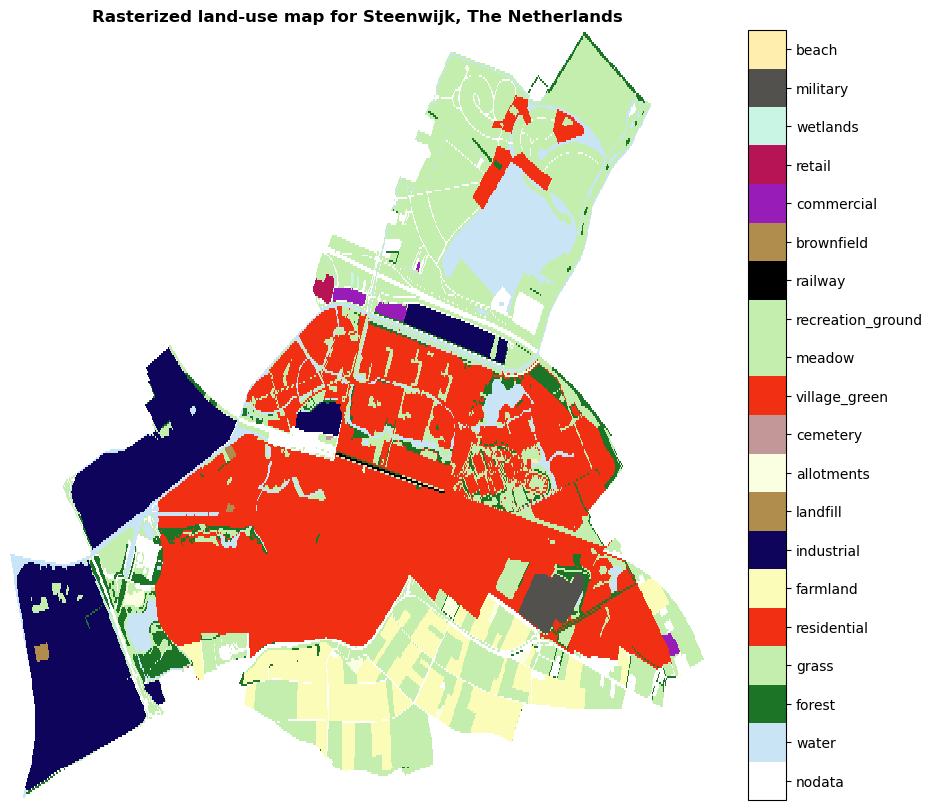

In [190]:
fig, ax = plt.subplots(1, 1,figsize=(14,10))

ax = landuse_valued["landuse_value"].plot(levels=len(unique_classes), cmap=cm, norm=norm)

# remove the ax labels
diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cb = fig.colorbar(ax, format=fmt, ticks=tickz)

fig.axes[0].set_title('Rasterized land-use map for {}'.format(place_name),fontweight='bold')

fig.axes[0].set_xticks([])
fig.axes[0].set_yticks([])
fig.axes[0].set_axis_off()

# for some weird reason we get two colorbars, so we remove one:
fig.delaxes(fig.axes[1])

## 4. Extracting buildings from OpenStreetMap
<hr>

There is a lot more data to extract from OpenStreetMap besides land-use information. Let's extract some building data. To do so, we use the *"building"* tag.

In [17]:
tags = {"building": True}
buildings = ox.geometries_from_place(place_name, tags)

Now let's see what information is actually extracted:

In [18]:
buildings.head()

addr:city addr:housenumber addr:postcode  \
element_type osmid                                                  
node         2823618780  Steenwijk               15        8332JD   
way          58337006          NaN              NaN           NaN   
             58343657          NaN              NaN           NaN   
             265889057         NaN              NaN           NaN   
             265889058   Steenwijk               21        8332JE   

                             addr:street building                     name  \
element_type osmid                                                           
node         2823618780      Parallelweg   public    Wijkcentrum De Oerthe   
way          58337006                NaN      yes                      NaN   
             58343657                NaN     roof                      NaN   
             265889057               NaN      yes  Dierenkliniek Steenwijk   
             265889058   Woldmeentherand      yes               McDonald's   

                           source source:date  \
element_type osmid                              
node         2823618780       BAG  2014-03-24   
way          58337006    3dShapes         NaN   
             58343657         NaN         NaN   
             265889057        BAG  2014-02-11   
             265889058        BAG  2020-01-02   

                                                                  geometry  \
element_type osmid                                                           
node         2823618780                           POINT (6.13482 52.78944)   
way          58337006    POLYGON ((6.10044 52.78450, 6.10086 52.78442, ...   
             58343657    POLYGON ((6.12222 52.79196, 6.12202 52.79200, ...   
             265889057   POLYGON ((6.12290 52.79493, 6.12284 52.79494, ...   
             265889058   POLYGON ((6.12035 52.79910, 6.12013 52.79915, ...   

                        emergency  ... website social_facility  \
element_type osmid                 ...                           
node         2823618780       NaN  ...     NaN             NaN   
way          58337006         NaN  ...     NaN             NaN   
             58343657         NaN  ...     NaN             NaN   
             265889057        NaN  ...     NaN             NaN   
             265889058        NaN  ...     NaN             NaN   

                        social_facility:for designation substation note:BAG  \
element_type osmid                                                            
node         2823618780                 NaN         NaN        NaN      NaN   
way          58337006                   NaN         NaN        NaN      NaN   
             58343657                   NaN         NaN        NaN      NaN   
             265889057                  NaN         NaN        NaN      NaN   
             265889058                  NaN         NaN        NaN      NaN   

                        bridge:support construction ways type  
element_type osmid                                             
node         2823618780            NaN          NaN  NaN  NaN  
way          58337006              NaN          NaN  NaN  NaN  
             58343657              NaN          NaN  NaN  NaN  
             265889057             NaN          NaN  NaN  NaN  
             265889058             NaN          NaN  NaN  NaN  

[5 rows x 64 columns]

As you notice in the output of the cell above, there are many columns which just contain "NaN". And there even seem to be to many columns to even visualize properly in one view.

Let's check what information is collected for the different buildings:

In [19]:
buildings.columns

Index(['addr:city', 'addr:housenumber', 'addr:postcode', 'addr:street',
       'building', 'name', 'source', 'source:date', 'geometry', 'emergency',
       'opening_hours', 'nodes', 'man_made', 'layer', 'amenity', 'ref:bag',
       'start_date', 'addr:country', 'brand', 'brand:wikidata',
       'brand:wikipedia', 'contact:phone', 'contact:website', 'cuisine',
       'delivery', 'description', 'drive_through', 'internet_access',
       'internet_access:fee', 'takeaway', 'toilets:wheelchair', 'wheelchair',
       'religion', 'heritage', 'ref:bag:old', 'power', 'shop',
       'building:levels', 'addr:housename', 'architect', 'architect:wikidata',
       'building:architecture', 'heritage:operator', 'historic', 'note',
       'ref:rce', 'survey:date', 'wikidata', 'wikipedia', 'year',
       'roof:levels', 'official_name', 'operator', 'denomination', 'website',
       'social_facility', 'social_facility:for', 'designation', 'substation',
       'note:BAG', 'bridge:support', 'construction', 

## 5. Analyze and visualize building stock
<hr>

What we also noticed is that quite some buildings are identified as 'yes'. This is not very useful as it does not really say much about the use of the building. 

Let's see for how many buildings this is the case: 

In [20]:
buildings.building.value_counts()

house             6449
yes               4617
industrial         218
apartments         174
retail              72
construction        59
commercial          56
static_caravan      23
roof                11
houseboat            6
shed                 5
office               5
school               3
church               3
civic                1
service              1
public               1
Name: building, dtype: int64

Now let's visualize the buildings again. We need to create a similar color dictionary as we did for the land-use categories. Now its up to you to make it!

In [21]:
color_dict = {  "grass":'#c3eead',               "railway": "#000000",
                "forest":'#1c7426',              "orchard":'#fe6729',
                "residential":'#f13013',         "industrial":'#0f045c',
                "retail":'#b71456',              "education":'#d61181',              
                "commercial":'#981cb8',          "farmland":'#fcfcb9',
                "cemetery":'#c39797',            "construction":'#c0c0c0',
                "meadow":'#c3eead',              "farmyard":'#fcfcb9',
                "plant_nursery":'#eaffe2',       "scrub":'#98574d',
                "allotments":'#fbffe2',          "reservoir":'#8af4f2',
                "static_caravan":'#ff3a55',      "wetlands": "#c9f5e5",
                "water": "#c9e5f5",              "beach": "#ffeead",}


# Remove multiple keys from dictionary
color_dict = {key: color_dict[key]
             for key in color_dict if key not in  list(set(color_dict)-set(landuse.landuse.unique()))}

map_dict = dict(zip(color_dict.keys(),[x for x in range(len(color_dict))]))

And plot the figure in the same manner!

Text(0.5, 1.0, 'Steenwijk, The Netherlands')

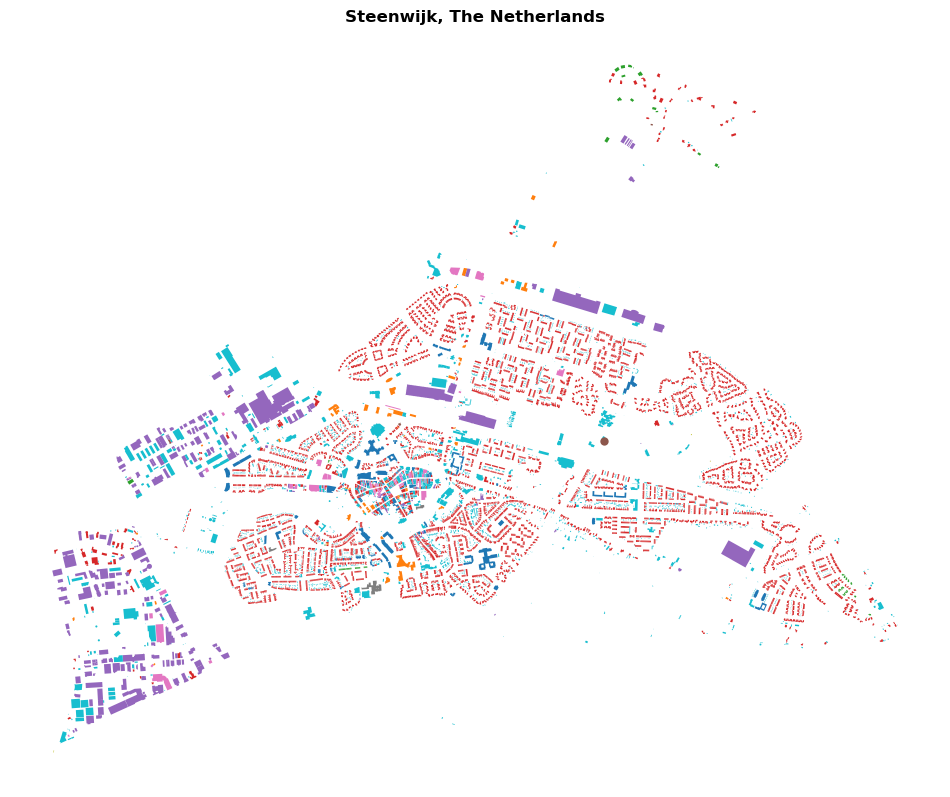

In [22]:
# Plot the figure
fig, ax = plt.subplots(1, 1,figsize=(12,10))
color_scheme_map = list(color_dict.values())

cmap = LinearSegmentedColormap.from_list(name='landuse',
                                     colors=color_scheme_map)  

buildings.plot(column='building',ax=ax,linewidth=0)

ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()
#legend_elements = []
#for iter_,item in enumerate(color_dict):
#    legend_elements.append(Patch(facecolor=color_scheme_map[iter_],label=item))        

#ax.legend(handles=legend_elements,edgecolor='black',facecolor='#fefdfd',prop={'size':12},loc=(1.02,0.2)) 

ax.set_title(place_name,fontweight='bold')

## 6. Extracting roads from OpenStreetMap
<hr>

Let's continue (and end) this tutorial with the core data in OpenStreetMap (it is even in the name): roads!

Now, instead of using tags, we want to identify what type of roads we would like to extract. Let's first only extract roads that can be used to drive.

In [23]:
G = ox.graph_from_place(place_name, network_type="drive")

In [24]:
# plot the street network with folium
m1 = ox.plot_graph_folium(G, popup_attribute="name", weight=2, color="#8b0000")

In [25]:
m1

## 7. Plot Routes Using OpenStreetMap and Folium
<hr>

One of the exiting things we can do with this data is that we can compute and plot routes between two points on a map.

In [26]:
# use networkx to calculate the shortest path between two nodes
origin_node = list(G.nodes())[0]
destination_node = list(G.nodes())[-1]
route = nx.shortest_path(G, origin_node, destination_node)

In [27]:
# plot the route with folium
# like above, you can pass keyword args along to folium PolyLine to style the lines
m2 = ox.plot_route_folium(G, route, weight=10)

In [28]:
m2

In [29]:
# plot the route with folium on top of the previously created graph_map
m3 = ox.plot_route_folium(G, route, route_map=m1, popup_attribute="length", weight=7)

In [30]:
# save as html file then display map as an iframe
m3